In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import scipy.optimize

In [2]:
lung_onda = 650e-09
L = 0.99
b = 0.08e-03

In [3]:
df = pd.read_csv('Capstone_Data.csv',delimiter=',')
n = df.shape[1] #number of columns

set_names = []
k = 0
d = {}
for i in range(0,n,2):
    set_names.append(df.columns[::][i].rpartition(' ')[2])
    #print(set_names[k])
    d[set_names[k]] = df.iloc[:,i:i+2].dropna()
    k +=1

In [4]:
#tolgo già qui gli zeri
Table1 = d['Antonio_0.08_1.5_lampadina'].loc[((d['Antonio_0.08_1.5_lampadina'].iloc[:,1] != 0) )]
Table2 = d['Alessio_0.08_1.5_lampadina'].loc[((d['Alessio_0.08_1.5_lampadina'].iloc[:,1] != 0) )]
Table3 = d['Alessandra_0.08_1.5_lampadina'].loc[((d['Alessandra_0.08_1.5_lampadina'].iloc[:,1] != 0) )]
Table4 = d['Antonio_0.08_0.5_lampadina'].loc[((d['Antonio_0.08_0.5_lampadina'].iloc[:,1] != 0) )]

In [5]:
#sottriamo la media del rumore ambientale
threshold = d['rumore_abientale_1.5_candela'].iloc[:,1].mean() 
threshold

0.01357795647969053

In [6]:
Table4.iloc[:,1]

14     -1.972500e-05
15     -1.972500e-05
16     -1.972500e-05
17     -1.972500e-05
18     -1.972500e-05
            ...     
1874    2.189340e-16
1875    2.189340e-16
1876    2.189340e-16
1877    2.189340e-16
1878    2.189340e-16
Name: Position (m) Antonio_0.08_0.5_lampadina, Length: 1865, dtype: float64

In [7]:
def preprocessing(Table, threshold):
    Idata = Table.iloc[:,0].values - threshold
    xdata = Table.iloc[:,1].values
    #print(len(xdata))

    MaxIntensity = np.max(Idata)
    maxint = np.argmax(Idata)
    xdata = (xdata-xdata[maxint])
    
    #errors
    xdataerr = np.ones(len(xdata))*8e-6 #secondo il manuale
    err_y = d['intensità_laser_sole'].iloc[:,1].std()/100*3 #manuale
    Idataerr = np.ones(len(xdata))*err_y
    return Idata, xdata, MaxIntensity, xdataerr, Idataerr

In [8]:
Idata, xdata, MaxIntensity, xdataerr, Idataerr = preprocessing(Table1, threshold)
Idata2, xdata2, MaxIntensity2, xdataerr2, Idataerr2 = preprocessing(Table2, threshold)
Idata3, xdata3, MaxIntensity3, xdataerr3, Idataerr3 = preprocessing(Table3, threshold)
Idata4, xdata4, MaxIntensity4, xdataerr4, Idataerr4 = preprocessing(Table4, threshold)

In [9]:
def distanceFunctionFit(x,b,intensity):
    return (intensity*((np.sin(np.pi*b/lung_onda*np.sin(np.arctan(x/L))))/(np.pi*b/lung_onda*np.sin(np.arctan(x/L))))**2)

#tolgo il massimo(?)
def del_zeros(xdata,Idata,Idataerr):
    xdata1 = []
    Idata1 = []
    Idataerr1 = []
    for i in range(len(Idata)):
        if(xdata[i] != 0):
            xdata1.append(xdata[i])
            Idata1.append(Idata[i])
            Idataerr1.append(Idataerr[i])
    #print(len(xdata1))
    return xdata1, Idata1, Idataerr1

In [10]:
xdata1, Idata1, Idataerr1 = del_zeros(xdata,Idata,Idataerr) 
xdata12, Idata12, Idataerr12 = del_zeros(xdata2,Idata2,Idataerr2) 
xdata13, Idata13, Idataerr13 = del_zeros(xdata3,Idata3,Idataerr3) 
xdata14, Idata14, Idataerr14 = del_zeros(xdata4,Idata4,Idataerr4) 

In [11]:
def distanceFunctionFit(x,b,intensity):
    return intensity*((np.sin(np.pi*b*(x/L)/lung_onda))/(np.pi*b*(x/L)/lung_onda))**2

def fitting(b,MaxIntensity,xdata,Idata,Idataerr):
    #simulation
    x = np.linspace(min(xdata),max(xdata),1000)
    y = distanceFunctionFit(x,b,MaxIntensity)

    popt, pcov = scipy.optimize.curve_fit(distanceFunctionFit, xdata, Idata,sigma = Idataerr, p0 = (b,MaxIntensity))
    bfit,intensity = popt #variabili
    intensityerr,bfiterr = np.sqrt(np.diag(pcov)) #errori
    
    xfitb = np.linspace(min(xdata), max(xdata), 1000)
    yfitb = distanceFunctionFit(xfitb,bfit,intensity)
    return x,y, xfitb, yfitb,bfit, bfiterr

In [12]:
x1,y1, xfitb1, yfitb1, bfit1, bfiterr1 = fitting(b,MaxIntensity,xdata1,Idata1,Idataerr1)
print(("bfit1 = %g +- %g")%(bfit1, bfiterr1))
x2,y2, xfitb2, yfitb2, bfit12, bfiterr12 = fitting(b,MaxIntensity2,xdata12,Idata12,Idataerr12)
print(("bfit2 = %g +- %g")%(bfit12, bfiterr12))
x3,y3, xfitb3, yfitb3, bfit13, bfiterr13 = fitting(b,MaxIntensity3,xdata13,Idata13,Idataerr13)
print(("bfit3 = %g +- %g")%(bfit13, bfiterr13))
x3,y3, xfitb4, yfitb4, bfit14, bfiterr14 = fitting(b,MaxIntensity4,xdata14,Idata14,Idataerr14)
print(("bfit4 = %g +- %g")%(bfit14, bfiterr14))

bfit1 = 7.82875e-05 +- 0.0211613
bfit2 = 8.03705e-05 +- 0.0141339
bfit3 = 7.95996e-05 +- 0.0120041
bfit4 = 8.35846e-05 +- 0.0119159


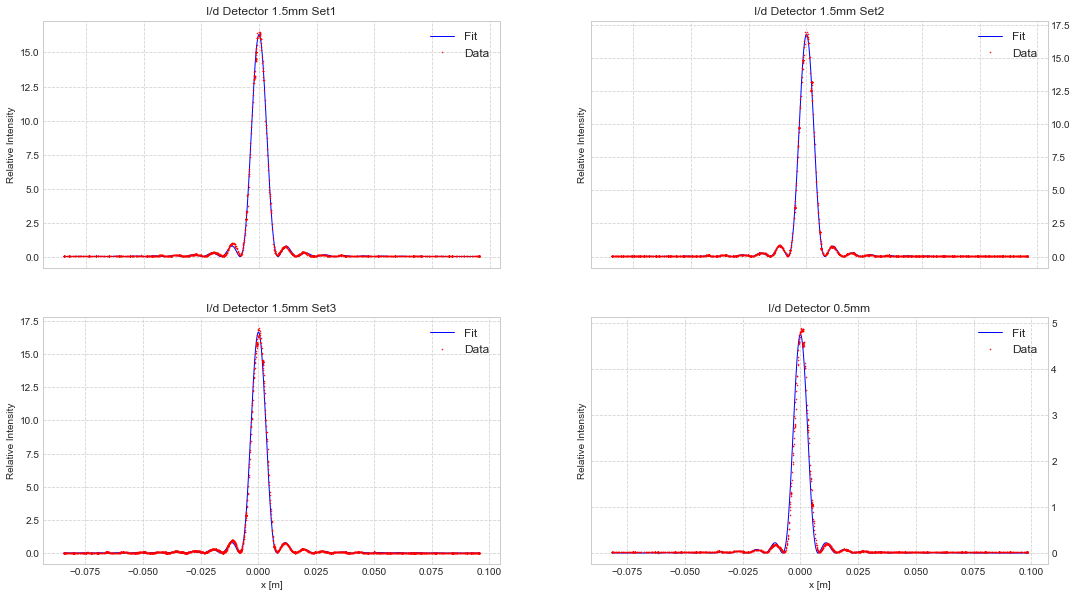

In [13]:
#graphs

fig, axs = plt.subplots(2, 2,figsize=(18, 10)) 
axs[0, 0].grid(color='lightgray',linestyle="--",zorder=0)
axs[0, 0].plot(xfitb1, yfitb1, linewidth=1, zorder=3, color="blue", label='Fit')
#axs[0, 0].plot(x,y, label="Simulation", color="orange", linewidth=3, zorder=1)
axs[0, 0].errorbar(xdata1,Idata1,label="Data", color = "red", fmt='o', markersize=0.55, zorder=4)
axs[0, 0].set_title('I/d Detector 1.5mm Set1')
axs[0, 0].legend(loc=1, prop={'size': 12});

axs[0, 1].grid(color='lightgray',linestyle="--",zorder=0)
axs[0, 1].plot(xfitb2, yfitb2, linewidth=1, zorder=3, color="blue", label='Fit')
#axs[0, 1].plot(x2,y2, label="Simulation", color="orange", linewidth=3, zorder=1)
axs[0, 1].errorbar(xdata12,Idata12,label="Data", color = "red", fmt='o', markersize=0.55, zorder=4)
axs[0, 1].set_title('I/d Detector 1.5mm Set2')
axs[0, 1].legend(loc=1, prop={'size': 12});

axs[1, 0].grid(color='lightgray',linestyle="--",zorder=0)
axs[1, 0].plot(xfitb3, yfitb3, linewidth=1, zorder=3, color="blue", label='Fit')
#axs[1, 0].plot(x3,y3, label="Simulation", color="orange", linewidth=3, zorder=1)
axs[1, 0].errorbar(xdata13,Idata13,label="Data", color = "red", fmt='o', markersize=0.55, zorder=4)
axs[1, 0].set_title('I/d Detector 1.5mm Set3')
axs[1, 0].legend(loc=1, prop={'size': 12});

axs[1, 1].grid(color='lightgray',linestyle="--",zorder=0)
axs[1, 1].plot(xfitb4, yfitb4, linewidth=1, zorder=3, color="blue", label='Fit')
#axs[1, 1].plot(x4,y4, label="Simulation", color="orange", linewidth=3, zorder=1)
axs[1, 1].errorbar(xdata14,Idata14,label="Data", color = "red", fmt='o', markersize=0.55, zorder=4)
axs[1, 1].set_title('I/d Detector 0.5mm')
axs[1, 1].legend(loc=1, prop={'size': 12});
axs[1, 1].yaxis.tick_right()

for ax in axs.flat:
    ax.set(xlabel='x [m]', ylabel='Relative Intensity')
axs[0, 0].label_outer()
axs[0, 1].label_outer()
axs[0, 1].yaxis.tick_right()
axs[0, 1].set(ylabel='Relative Intensity')
plt.show()